In [1]:
import torch
from utils import model_loader
from PIL import Image
from transformers import CLIPTokenizer

/home/mlfavorfit/anaconda3/envs/diffusion/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache()

## Device Check

In [3]:
DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

Using device: cuda


## Load CLIP model

In [4]:
tokenizer = CLIPTokenizer("./data/vocab.json", merges_file="./data/merges.txt")

## Convert HS Diffusion => Favorfit Diffusion

In [5]:
from utils.model_converter import convert_model

model_file = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/v1-5-pruned-emaonly.ckpt"
state_dict = torch.load(model_file)['state_dict']
converted_state_dict = convert_model(state_dict)

2024-01-31 11:07:58.012527: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-31 11:07:58.013458: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-31 11:07:58.031736: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 11:07:58.405502: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


---
## Text to Image

In [6]:
models = model_loader.load_diffusion_model(converted_state_dict)

100%|██████████| 20/20 [00:01<00:00, 11.83it/s]


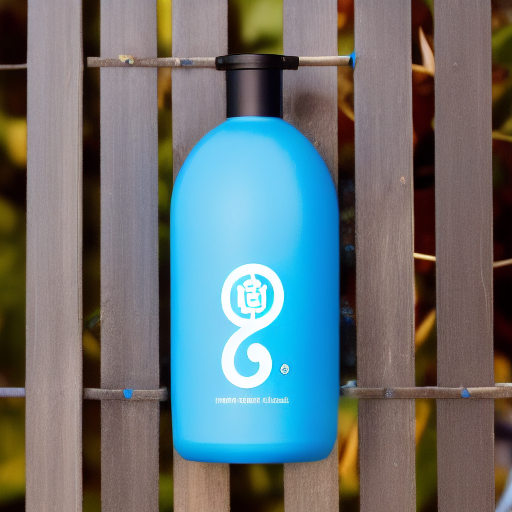

In [7]:
from pipelines.pipeline_default import generate
output_image = generate(
    prompt="A blue bottle",
    uncond_prompt="deform, low quality",
    input_image=None,
    do_cfg=True,
    cfg_scale=8,
    sampler_name="ddpm",
    n_inference_steps=20,
    seed=42,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

Image.fromarray(output_image)

---
## Inpainting

- convert inpainting diffusion model

In [8]:
from utils.model_converter import convert_model

model_file = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/sd-v1-5-inpainting.ckpt"
state_dict = torch.load(model_file)['state_dict']
converted_state_dict = convert_model(state_dict)

In [9]:
from utils.model_loader import load_diffusion_model

kwargs = {"is_inpaint":True}
models = load_diffusion_model(converted_state_dict, **kwargs)

In [10]:
from PIL import Image

def make_inpaint_data(image_path, mask_path):
    img_pil = Image.open(image_path).convert("RGB")
    mask_pil = Image.open(mask_path).convert("L")
    return img_pil, mask_pil

In [11]:
image_path = "./images/test_image/bottle.jpg"
mask_path = "./images/test_image/mask.png"

input_image, mask = make_inpaint_data(image_path, mask_path)

100%|██████████| 20/20 [00:01<00:00, 12.58it/s]


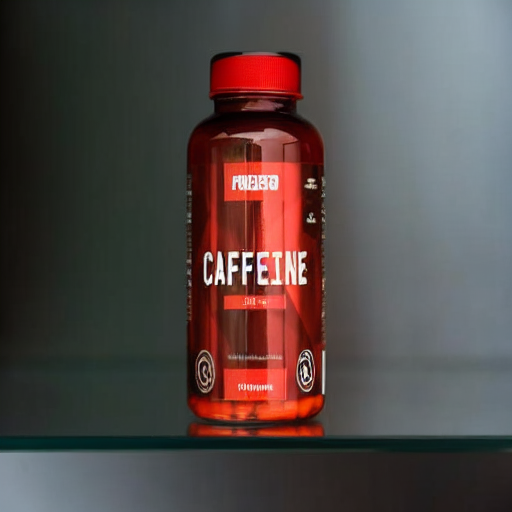

In [12]:
from pipelines.pipeline_inpainting import generate
output_image = generate(
    prompt="red bottle cap, high resolution, 8k",
    uncond_prompt="deform, low quality",
    input_image=input_image,
    mask_image=mask,
    strength=1.0,
    do_cfg=True,
    cfg_scale=8,
    sampler_name="ddpm",
    n_inference_steps=20,
    seed=42,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

Image.fromarray(output_image)

## Controlnet
---

In [18]:
from utils.model_converter import convert_model, convert_controlnet_model
import torch

In [19]:
diffusion_state_dict = torch.load("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/v1-5-pruned-emaonly.ckpt")["state_dict"]
control_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/controlnet/control_v11f1e_sd15_tile.pth")

diffusion_state_dict = convert_model(diffusion_state_dict)
control_state_dict = convert_controlnet_model(control_state_dict)

In [20]:
from utils.model_loader import load_diffusion_model, load_controlnet_model

kwargs = {"is_controlnet":True, "controlnet_scale":1.0}

models = load_diffusion_model(diffusion_state_dict, **kwargs)
controlnet = load_controlnet_model(control_state_dict)

models.update(controlnet)

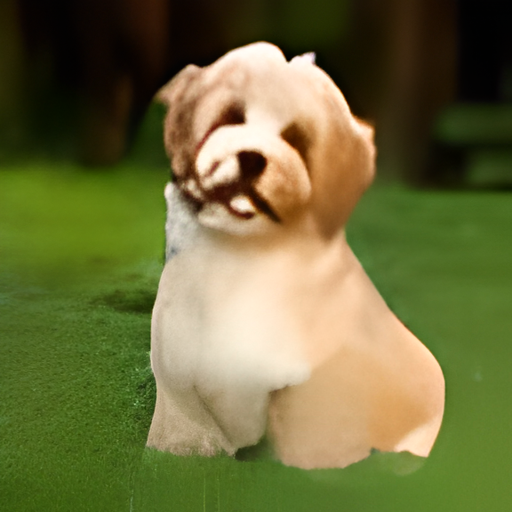

In [21]:
from PIL import Image

# control_image = Image.open("./images/dog_bad_sr.png").convert("RGB")
control_image = Image.open("./images/dog_bad_sr.png").convert("RGB")
control_image = control_image.resize((512,512))
control_image

100%|██████████| 20/20 [00:01<00:00, 14.16it/s]


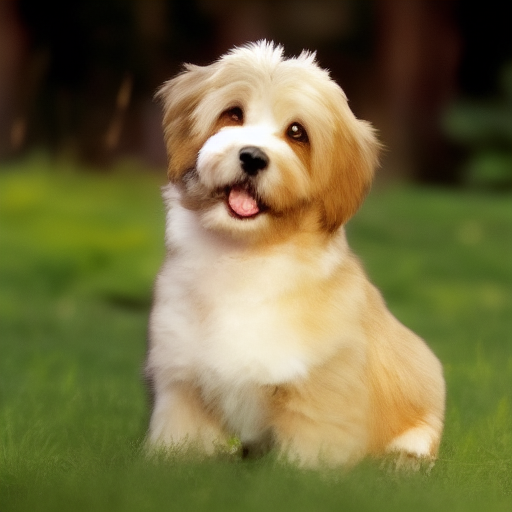

In [22]:
from pipelines.pipline_default_controlnet import generate
output_image = generate(
    prompt="dog on grassland",
    uncond_prompt="deform, low quality",
    input_image=control_image,
    control_image=control_image,
    do_cfg=False,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=20,
    strength=1.0,
    models=models,
    seed=12345,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer
)

Image.fromarray(output_image)

## Lora

---

In [5]:
from safetensors.torch import load_file
from utils.model_converter import convert_model, convert_lora_model

In [6]:
lora_state_dict = load_file("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/lora/train/pytorch_lora_weights.safetensors")
lora_state_dict = convert_lora_model(lora_state_dict)

In [7]:
diffusion_state_dict = torch.load("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/v1-5-pruned-emaonly.ckpt")["state_dict"]
diffusion_state_dict = convert_model(diffusion_state_dict)

lora_state_dict = load_file("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/lora/train/pytorch_lora_weights.safetensors")
lora_state_dict = convert_lora_model(lora_state_dict)

diffusion_state_dict["lora"] = lora_state_dict

2024-01-27 16:16:12.657957: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-27 16:16:12.658992: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-27 16:16:12.678487: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-27 16:16:13.072788: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
from utils.model_loader import load_diffusion_model

kwargs = {"is_lora":True, "lora_scale":1.0}
models = load_diffusion_model(diffusion_state_dict, **kwargs)

100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


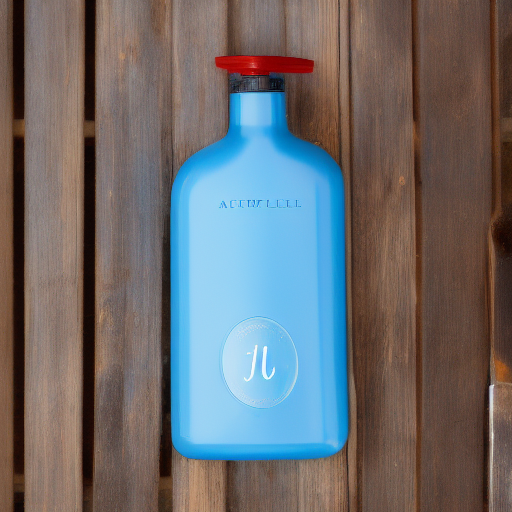

In [9]:
from pipelines.pipeline_default import generate
output_image = generate(
    prompt="A blue bottle",
    uncond_prompt="deform, low quality",
    input_image=None,
    do_cfg=True,
    cfg_scale=8,
    sampler_name="ddpm",
    n_inference_steps=20,
    seed=42,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

Image.fromarray(output_image)

## Refenence Style
---

In [4]:
from utils.model_loader import load_diffusion_model, load_controlnet_model

diffusion_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/favorfit_base.pth")
control_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/controlnet/outpaint_v2.pth")

kwargs = {"is_controlnet":True, "controlnet_scale":1.0, "is_lora":True, "lora_scale":0.3, "clip_image_encoder":True, "clip_dtype":torch.float16}
models = load_diffusion_model(diffusion_state_dict, **kwargs)
controlnet = load_controlnet_model(control_state_dict)

models.update(controlnet)

2024-01-31 11:27:06.516117: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-31 11:27:06.517062: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-31 11:27:06.532840: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 11:27:06.918282: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


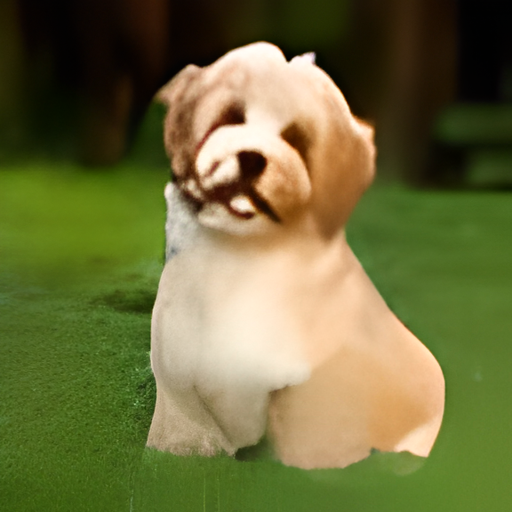

In [5]:
from PIL import Image

ref_image = Image.open("./images/dog_bad_sr.png").convert("RGB")
ref_image = ref_image.resize((512,512))
ref_image

100%|██████████| 20/20 [00:01<00:00, 10.41it/s]


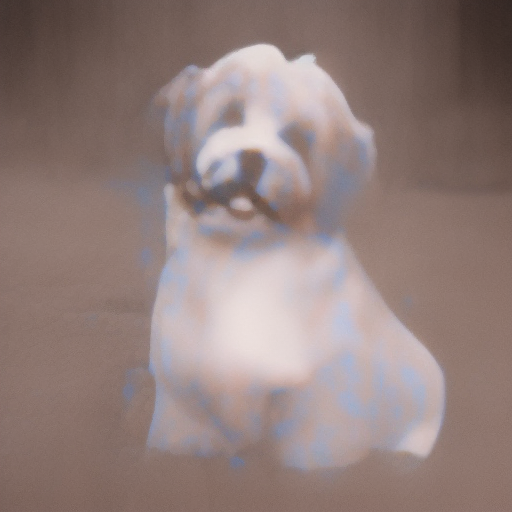

In [6]:
from pipelines.pipeline_reference import generate

output_image = generate(
    ref_image=ref_image,
    unref_image=None,
    input_image=None,
    control_image=ref_image,
    strength=0.8,
    do_cfg=False,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=20,
    models=models,
    seed=42,
    device=DEVICE,
    idle_device="cpu",
)

Image.fromarray(output_image)

## Color palette text inversion
---

In [5]:
from utils.model_converter import convert_model
import torch

In [6]:
diffusion_state_dict = torch.load("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/v1-5-pruned-emaonly.ckpt")["state_dict"]
diffusion_state_dict = convert_model(diffusion_state_dict)

2024-01-27 16:33:15.088850: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-27 16:33:15.089867: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-27 16:33:15.108890: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-27 16:33:15.488537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
from utils.model_loader import load_diffusion_model, load_color_palette_embedding_model
kwargs = {"clip_train":True}
models = load_diffusion_model(diffusion_state_dict, **kwargs)
embedding = load_color_palette_embedding_model(state_dict=None)

models.update(embedding)

100%|██████████| 20/20 [00:01<00:00, 11.59it/s]


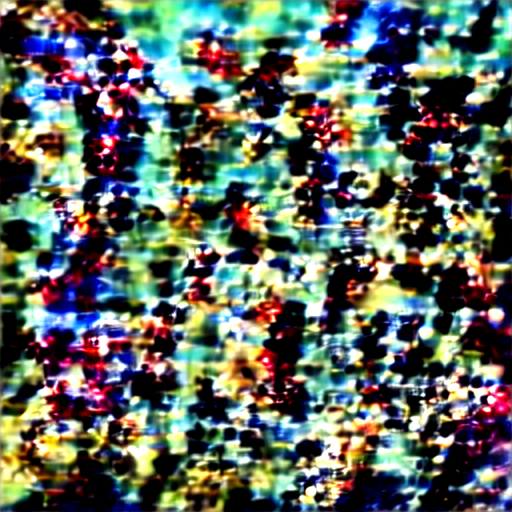

In [8]:
from pipelines.pipline_color_palette import generate
output_image = generate(
    prompt="the cute cat",
    uncond_prompt="",
    color_palette=[[31, 29, 27], [135, 137, 145], [94, 92, 97], [68, 66, 70]],
    do_cfg=True,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=20,
    models=models,
    seed=42,
    device="cuda",
    idle_device="cpu",
    tokenizer=tokenizer,
)

Image.fromarray(output_image)